<a href="https://www.kaggle.com/code/hermengardo/ps6e2-eda-nn?scriptVersionId=295292761" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="font-family: serif; font-weight: bold; text-align: center;">
  <h1>✨ Imports</h1>
</div>

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import polars as pl
import re
import seaborn as sns
import tensorflow as tf
import warnings
import optuna

from dataclasses import dataclass
from matplotlib.patches import Patch
from sklearn.metrics import mean_absolute_error, roc_auc_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, LSTM
from tensorflow.keras.models import Sequential
from ydata_profiling import ProfileReport

warnings.filterwarnings("ignore")

2026-02-01 13:48:14.072670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769953694.249909      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769953694.304561      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769953694.746973      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769953694.747020      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769953694.747024      24 computation_placer.cc:177] computation placer alr

In [2]:
rc = {
    "axes.facecolor": "#fff",
    "axes.edgecolor": "#0e0e0e",
    "figure.facecolor": "#fff",
    "grid.color": "#0e0e0e",
    "axes.grid": True,
    
    "grid.linestyle":"--",
    "axes.labelcolor": "#0e0e0e",
    "xtick.color": "#0e0e0e",
    "ytick.color": "#0e0e0e",
    "legend.labelcolor": "#0e0e0e",
    "legend.edgecolor": "#fff",
    "patch.edgecolor": "#0B90A7",
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "font.size": 18,
    "font.family": "serif",
    "font.weight": "bold",
    "grid.alpha": 0.1,
}

props = {
    'boxprops': {'edgecolor': '#0e0e0e', 'alpha': 1},
    'medianprops': {'color': '#0e0e0e', 'linestyle': '-', 'linewidth': 0.7},
    'whiskerprops': {'color': '#0e0e0e', 'linestyle': '--', 'linewidth': 0.7},
    'capprops': {'color': '#0e0e0e', 'linewidth': 0.7},
    'flierprops': {'marker': 'o', 'markersize': 4, 'markerfacecolor': 'none', 'markeredgecolor': '#0e0e0e', 'markerfacecolor': '#fffdf7', 'linewidth': 0.7}
}

sns.set(rc=rc)

sns.despine()

<Figure size 640x480 with 0 Axes>

In [3]:
@dataclass
class settings():
    target:     str      = "Heart Disease"
    identifier: str|None = "id"
    
    epochs:           int      = 25
    batch_size:       int      = 128
    validation_split: float    = 0.2

params = settings()

<div style="font-family: serif; font-weight: bold; text-align: center;">
  <h1>✨ Loading</h1>
</div>

In [4]:
def read_data(directory:str) -> tuple:
    """
        Read CSV files from a directory and return train, test, and submission DataFrames.
    """
    data = {}
    for filename in os.listdir(directory):
        key = re.search("(.*).csv", filename).group(1)
        data[key] = pd.read_csv(
            os.path.join(
                directory, 
                filename
            )
        )
    
    train = data["train"]
    test  = data["test"]
    sub   = data["sample_submission"]
        
    return train, test, sub

In [5]:
train, test, sub = read_data("/kaggle/input/playground-series-s6e2")

train["Heart Disease"] = train["Heart Disease"].replace({
    "Presence":1,
    "Absence":0
}).copy()

train.head()

id  Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   0   58    1                4  152          239             0            0   
1   1   52    1                1  125          325             0            2   
2   2   56    0                2  160          188             0            2   
3   3   44    0                3  134          229             0            2   
4   4   58    1                4  140          234             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     158                1            3.6            2   
1     171                0            0.0            1   
2     151                0            0.0            1   
3     150                0            1.0            2   
4     125                1            3.8            2   

   Number of vessels fluro  Thallium  Heart Disease  
0                        2         7              1  
1                        0         3              0  
2                        0         3              0  
3                        0         3              0  
4                        3         3              1

<div style="font-family: serif; font-weight: bold; text-align: center;">
  <h1>
    ✨ EDA
  </h1>
</div>

* **What I’ve done in this section:**
  1. Auto EDA to quickly access what the dataframes look like.
     
* **Main takeaways:**
  1. Heart Disease is **highly correlated** with Chest pain type and Thalium.
  2. Chest pain of **type 4** is correlated with the presence of Heart Disease.
  3. Chest pain of **types 1, 2, and 3** is correlated with the absence of Heart Disease.
  4. Highly **imbalanced data** on FBS over 120 (92% of the data comes from the same category)
  5. ST depression zeros are possible **missing data (?)**
  6. **Old people** are more prone to having Heart Disease (no surprises, I guess)

In [6]:
report = ProfileReport(train, title="Auto EDA - Train Set", explorative=True)

report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
def ridgeline(df, x, row, title, xlabel, pallete="viridis"):
    """
    Given a DataFrame, a target column, and a categorical variable used for
    aggregation, this function produces a kde ridgeplot.
    
    See:
    https://seaborn.pydata.org/examples/kde_ridgeplot
    """
    sns.set_theme(rc={"axes.facecolor": (0, 0, 0, 0), "axes.grid": False})
    
    g = sns.FacetGrid(df, row=row, hue=row, aspect=8, height=2, palette=pallete)
    g.map(sns.kdeplot, x, bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=2.5)
    g.map(sns.kdeplot, x, clip_on=False, color="black", lw=2.5, bw_adjust=.5)
    g.refline(y=0, linewidth=2.5, linestyle="-", color="black", clip_on=False)

    def label(x, color, label):
        plt.gca().text(0, .2, label, fontweight="bold",
                       color=color, ha="left",
                       va="center", transform=plt.gca().transAxes)

    g.map(label, x)
    g.figure.suptitle(title, fontsize=16, fontweight="bold", y=1.05)
    g.set_xlabels(xlabel)

    g.figure.subplots_adjust(hspace=-.6)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    plt.show()

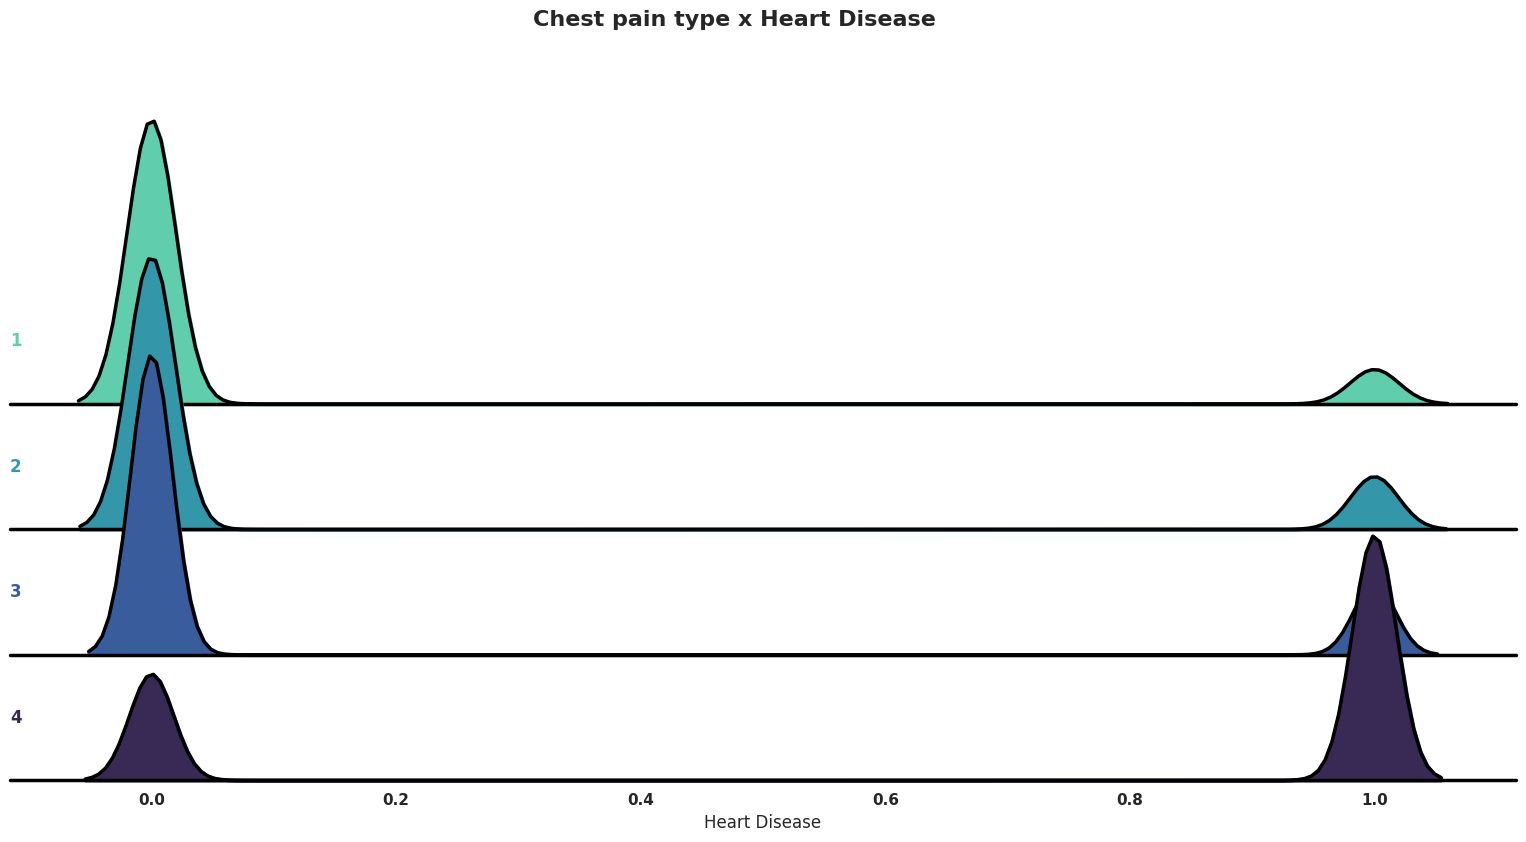

In [8]:
ridgeline(
    train,
    x="Heart Disease",
    row="Chest pain type",
    title=f"Chest pain type x Heart Disease",
    xlabel="Heart Disease",
    pallete="mako_r"
)

sns.set(rc=rc)

In [9]:
def plot_box(df, target, cols=3, colors=['#0B90A7','#E63946', '#E9C46A'], figsize=(15, 8), y_title=None, title=None, props=props):
    columns = df.select_dtypes('int').columns
    rows = np.ceil(len(columns) / cols).astype(int)

    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    
    yt_labels = []
    for i, x in enumerate(columns):
        if x == target:
            continue
            
        current_ax = ax[i // cols, i % cols]
        sns.boxplot(data=df, y=target, ax=current_ax, x=x, orient='h', palette=colors, **props)
        current_ax.set_xlabel(x)
        
        if y_title and i % cols == 0:
            if len(yt_labels) == 0:
                yt_labels = [label.get_text() for label in current_ax.get_yticklabels()]
            current_ax.set_ylabel(y_title)
            current_ax.set_yticklabels(yt_labels)
        else:
            current_ax.set_ylabel('')
            current_ax.set_yticklabels('')
            
    if title:
        fig.suptitle(title, fontsize=18, fontweight='bold')

    if len(columns) - 1 < (rows * cols):
        for i in range(len(columns) - 1, rows * cols):
            fig.delaxes(ax.flatten()[i])

    legend_elements = [
        Patch(facecolor=colors[0], edgecolor='black', label='Absence'),
        Patch(facecolor=colors[1], edgecolor='black', label='Presence')
    ]

    fig.legend(
        handles=legend_elements,
        loc='upper center',
        ncol=2,
        bbox_to_anchor=(0.5, .94),
        frameon=False
    )
    
    fig.tight_layout()
    plt.show()

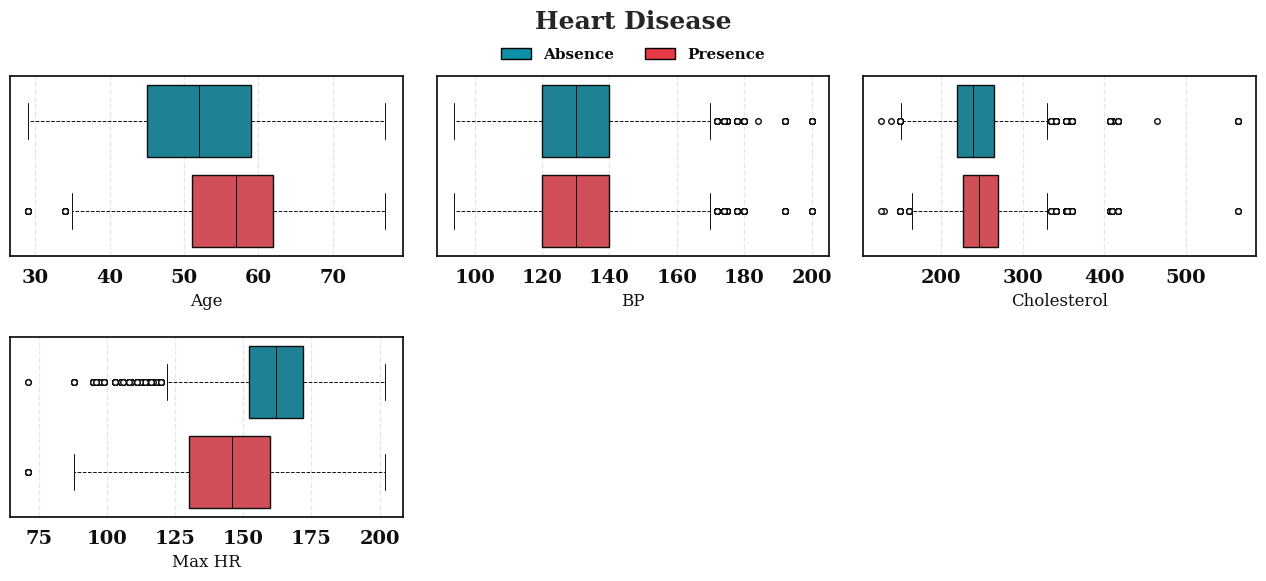

In [10]:
cat = ["id", "FBS over 120", 
       "Sex", "Chest pain type", 
       "EKG results", "Exercise angina", 
       "Slope of ST", "Number of vessels fluro", 
       "Thallium"]

plot_box(
    train.drop(cat, axis=1), 
    'Heart Disease', 
    figsize=(13, 6), 
    title='Heart Disease'
)

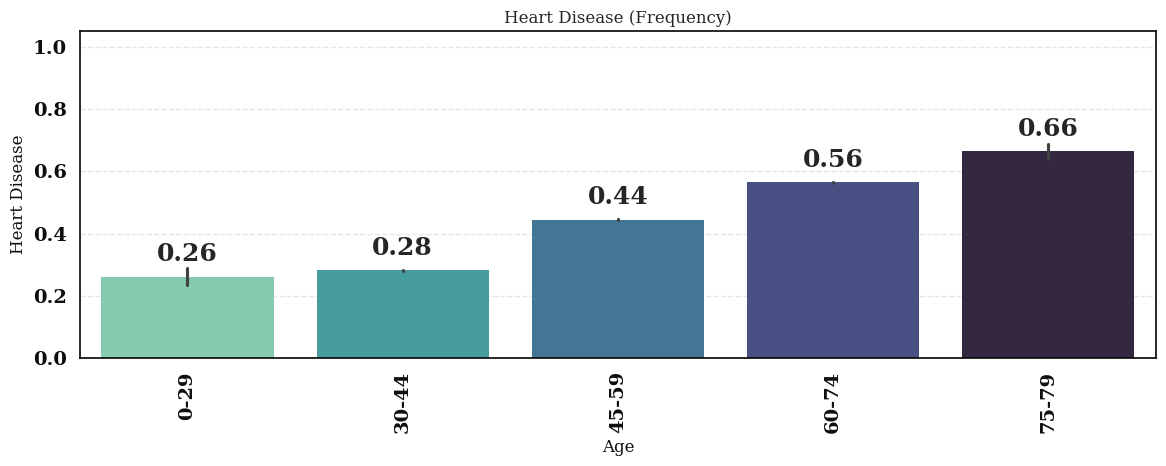

In [11]:
tmp = train.copy()

tmp['Age'] = pd.cut(tmp.Age, 
                    bins=[0, 30, 45, 60, 75, 80], 
                    labels=['0-29','30-44','45-59','60-74','75-79'], 
                    right=False)

plt.figure(figsize=(12,5))

sns.barplot(
    data=tmp,
    x="Age",
    y="Heart Disease",
    palette="mako_r",
    edgecolor="none"
)

for i, v in enumerate(tmp.groupby('Age')['Heart Disease'].mean()):
    plt.text(i, v + 0.05, f"{v:.2f}", ha='center')

plt.xticks(rotation=90)
plt.xlabel("Age")
plt.title("Heart Disease (Frequency)")

plt.ylim(0,1.05)
plt.tight_layout()
plt.show()

In [12]:
def plot_kde(df1:pd.DataFrame, 
             df2:pd.DataFrame, 
             cols:int = 3, 
             fill:bool = True, 
             figsize:tuple = (15, 12),
             colors:list = ["#0B90A7", "#E63946"], 
             title:str = None) -> None:

    df1 = df1.copy()
    df2 = df2.copy()

    df1.drop([settings().identifier, settings().target], axis=1, inplace=True)
    df2.drop([settings().identifier], axis=1, inplace=True)
    
    numeric_columns = df1.select_dtypes(include='number').columns
    rows = np.ceil(len(numeric_columns) / cols).astype(int)

    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)

    for i, x in enumerate(numeric_columns):
        current_ax = ax[i // cols, i % cols]
        sns.kdeplot(x=x,
                    color=colors[0],
                    fill=fill,
                    data=df1,
                    label='Train',
                    ax=current_ax)
        sns.kdeplot(x=x,
                    color=colors[1],
                    fill=fill,
                    data=df2,
                    label='Test',
                    ax=current_ax)
        current_ax.set_xlabel(x)
    
    if title:
        fig.suptitle(title, fontsize=18, fontweight='bold')

    if len(numeric_columns) < (rows * cols):
        for i in range(len(numeric_columns), rows * cols):
            fig.delaxes(ax.flatten()[i])

    legend_elements = [
        Patch(facecolor=colors[0], edgecolor='black', label='Train'),
        Patch(facecolor=colors[1], edgecolor='black', label='Test')
    ]

    fig.legend(
        handles=legend_elements,
        loc='upper center',
        ncol=2,
        bbox_to_anchor=(0.5, .96),
        frameon=False
    )

    fig.tight_layout()
    plt.show()

1. **Distributions look similar for both datasets**
2. **Class 1 is almost nonexistent on EKG results**
3. **Classes 2 and 3 of EKG results have similar proportions ~50/50**
4. **ST depression with a heavy right tail, mostly because of the zeroes**

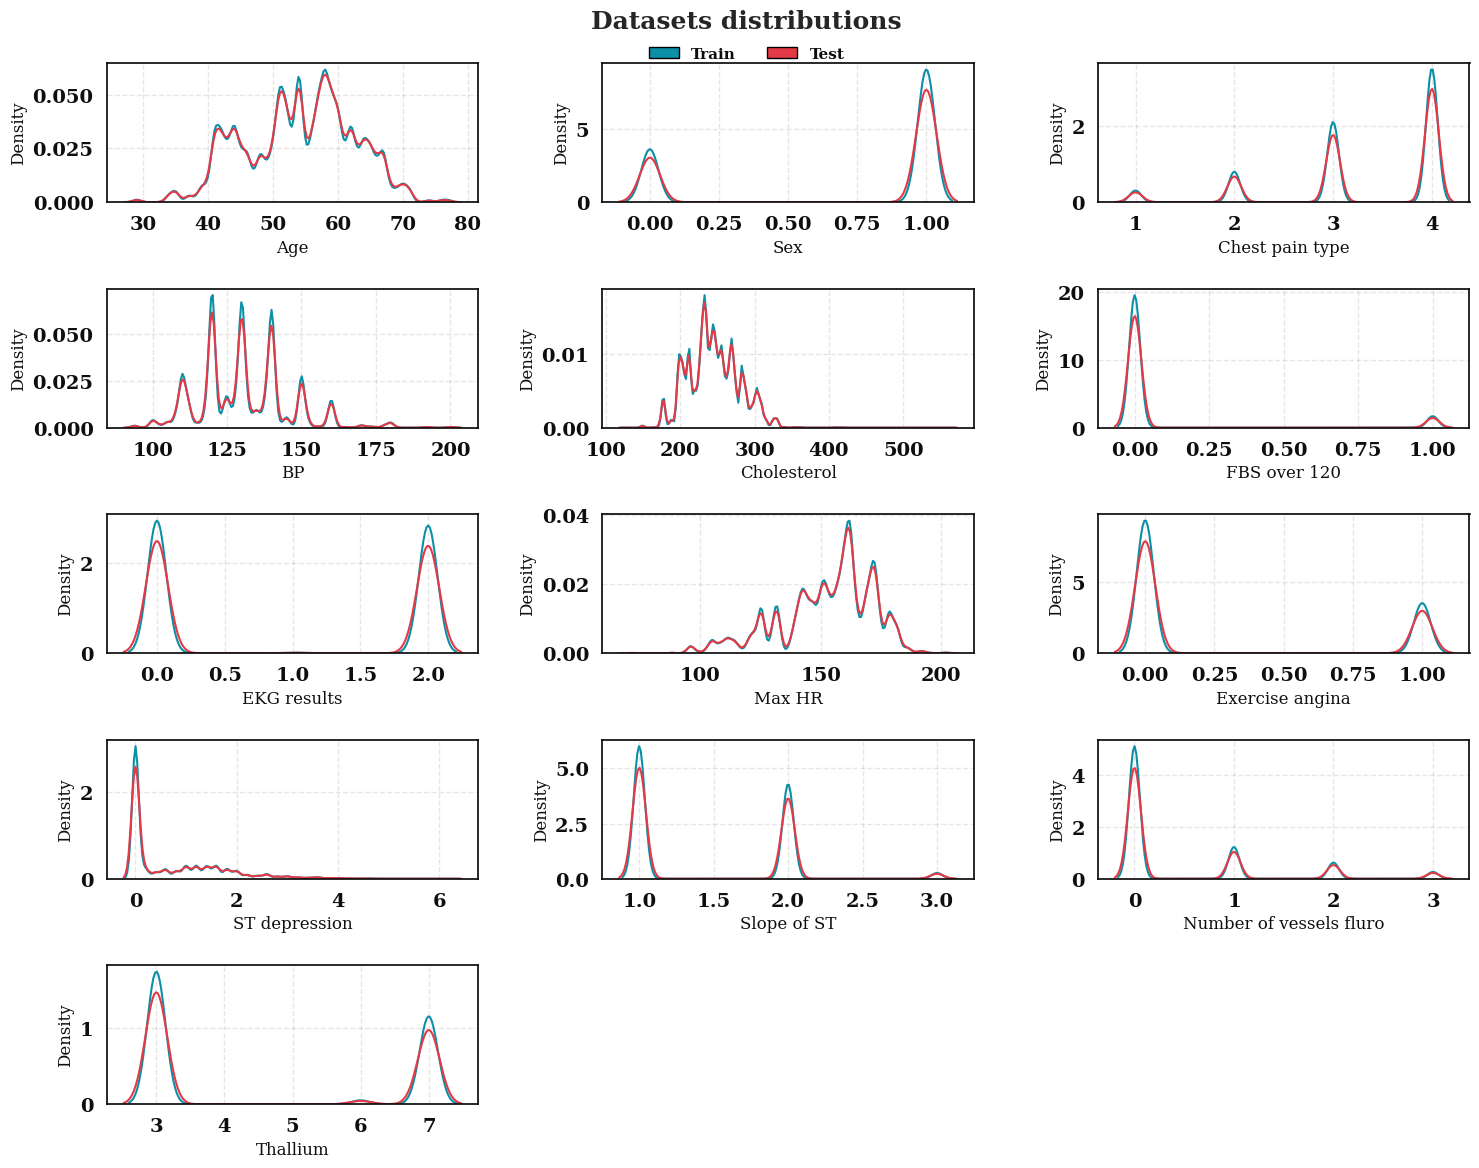

In [13]:
plot_kde(train, test, fill=False, title='Datasets distributions')

<div style="font-family: serif; font-weight: bold; text-align: center;">
  <h1>
    ✨ Model
  </h1>
</div>

1. Using a neural network because gradient-boosting models are great for Kaggle playgrounds, but they are also a bit boring.

In [14]:
for data in [train, test]:
    data.drop(["id", "FBS over 120", "ST depression"], axis=1, inplace=True)

In [15]:
X, y = train.drop("Heart Disease", axis=1), train["Heart Disease"].to_numpy(dtype=float)

X_test = test

In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

In [17]:
model = tf.keras.Sequential([
    layers.Dense(8, activation='relu', input_shape=(11,)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(4, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(2, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-4,
    weight_decay=1e-3
)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])

I0000 00:00:1769953797.383249      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [18]:
early_stop = EarlyStopping(
    monitor='val_auc',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X,
    y,
    batch_size=params.batch_size,
    epochs=params.epochs,
    validation_split=params.validation_split,
    callbacks=[early_stop]
)

Epoch 1/25


I0000 00:00:1769953801.320662      76 service.cc:152] XLA service 0x7aff20004a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769953801.320705      76 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1769953801.870248      76 cuda_dnn.cc:529] Loaded cuDNN version 91002


  62/3938 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - auc: 0.3947 - loss: 0.8836

I0000 00:00:1769953804.797925      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3938/3938 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - auc: 0.5687 - loss: 0.7199 - val_auc: 0.9029 - val_loss: 0.4648
Epoch 2/25
3938/3938 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - auc: 0.8390 - loss: 0.5006 - val_auc: 0.9390 - val_loss: 0.3320
Epoch 3/25
3938/3938 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - auc: 0.8942 - loss: 0.4157 - val_auc: 0.9442 - val_loss: 0.3048
Epoch 4/25
3938/3938 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - auc: 0.9064 - loss: 0.3932 - val_auc: 0.9462 - val_loss: 0.2982
Epoch 5/25
3938/3938 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - auc: 0.9093 - loss: 0.3877 - val_auc: 0.9474 - val_loss: 0.2943
Epoch 6/25
3938/3938 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - auc: 0.9122 - loss: 0.3818 - val_auc: 0.9479 - val_loss: 0.2923
Epoch 7/25
3938/3938 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - auc: 0.9140 - loss: 0.3784 - val_auc: 0.9482 - val_loss: 0.2909
Epoch 8/25
3938/3938 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - auc: 0.9144 - loss: 0.3774 - val_auc: 0.9484 - val_loss: 0.2901
Epoch 9/25
3938/3938 ━━━━━━━━━━━━━━━━━━━━ 1

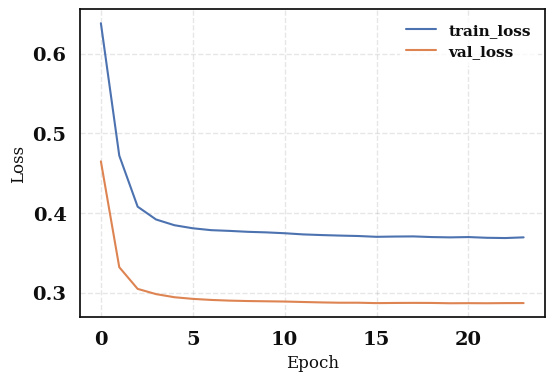

In [19]:
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

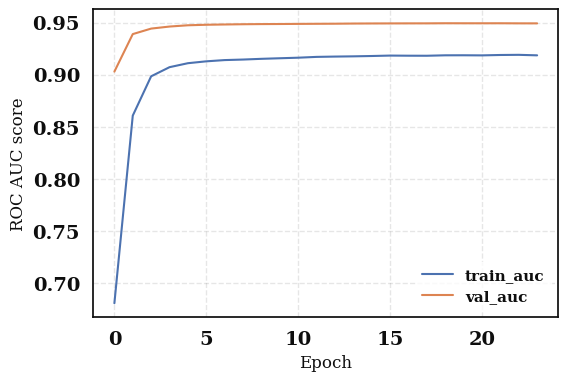

In [20]:
plt.figure(figsize=(6,4))
plt.plot(history.history["auc"], label="train_auc")
plt.plot(history.history["val_auc"], label="val_auc")
plt.xlabel("Epoch")
plt.ylabel("ROC AUC score")
plt.legend()
plt.show()

In [21]:
y_preds = model.predict(X_test)

8438/8438 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


In [22]:
sub["Heart Disease"] = y_preds.reshape(-1)

In [23]:
sub.to_csv('submission.csv', index=False)

In [24]:
sub.head()

id  Heart Disease
0  630000       0.970308
1  630001       0.007225
2  630002       0.985651
3  630003       0.011438
4  630004       0.160813